In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

In [2]:
epochs = 100

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/m3gofriends/My-Machine-and-Deep-Learning-Template-main/main/Data/CSV/auto-mpg.csv",
    na_values=['NA', '?'])

In [4]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [5]:
mean_std={}

# Remove target(Because the name of the car will hinder the training)
cars = df['name']

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Standardization
x_columns = df.columns.drop('name')
for var in x_columns:
  mean_std[var]=(df[var].mean(), df[var].std())
  df[var] = (df[var] - df[var].mean()) / df[var].std()

# Pandas to Numpy
x = df[x_columns].values
y = df['acceleration'].values # regression

In [6]:
mean_std

{'mpg': (23.514572864321607, 7.815984312565782),
 'cylinders': (5.454773869346734, 1.7010042445332119),
 'displacement': (193.42587939698493, 104.26983817119591),
 'horsepower': (104.30402010050251, 38.22262486810867),
 'weight': (2970.424623115578, 846.8417741973268),
 'acceleration': (15.568090452261307, 2.757688929812676),
 'year': (76.01005025125629, 3.697626646732623),
 'origin': (1.5728643216080402, 0.8020548777266148)}

In [7]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,-0.705551,1.496308,1.089233,0.672271,0.630077,-1.293870,-1.625381,-0.714246,chevrolet chevelle malibu
1,-1.089379,1.496308,1.501624,1.587959,0.853259,-1.475181,-1.625381,-0.714246,buick skylark 320
2,-0.705551,1.496308,1.194728,1.195522,0.549778,-1.656492,-1.625381,-0.714246,plymouth satellite
3,-0.961437,1.496308,1.060461,1.195522,0.546236,-1.293870,-1.625381,-0.714246,amc rebel sst
4,-0.833494,1.496308,1.041280,0.933897,0.565130,-1.837804,-1.625381,-0.714246,ford torino


In [8]:
# Split into train/test
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
# Train
print(x_train.shape)
print(x_test.shape) # Label

# Test
print(y_train.shape)
print(y_test.shape) # Label

(318, 8)
(318,)
(80, 8)
(80,)


In [10]:
x_train = torch.Tensor(x_train).cuda()
x_test = torch.Tensor(x_test).cuda()
y_train = torch.Tensor(y_train).cuda()
y_test = torch.Tensor(y_test).cuda()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [12]:
network = Net()
network.cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True, min_lr=1e-10)

In [13]:
train_losses = []
test_losses = []

In [14]:
def train(epoch):
  network.train()
  optimizer.zero_grad()
  pred = network(x_train)
  loss = F.mse_loss(pred.view(-1), x_test)
  loss.backward()
  optimizer.step()
  #scheduler.step(loss)

  print('Train Epoch : {}, MSE Loss : {:.6f}'.format(epoch, loss.item()))
  train_losses.append(loss.item())

In [15]:
def test(epoch):
  network.eval()
  with torch.no_grad():
    pred = network(y_train)
    loss = F.mse_loss(pred.view(-1), y_test)
    scheduler.step(loss)

  print('Test Epoch : {}, MSE Loss ; {:.6f}'.format(epoch, loss.item()))
  test_losses.append(loss.item())

In [16]:
for epoch in range(1, epochs+1):
  train(epoch)
  test(epoch)

Train Epoch : 1, MSE Loss : 1.180588
Test Epoch : 1, MSE Loss ; 0.609303
Train Epoch : 2, MSE Loss : 0.637263
Test Epoch : 2, MSE Loss ; 0.197642
Train Epoch : 3, MSE Loss : 0.274517
Test Epoch : 3, MSE Loss ; 0.132542
Train Epoch : 4, MSE Loss : 0.201544
Test Epoch : 4, MSE Loss ; 0.091832
Train Epoch : 5, MSE Loss : 0.161148
Test Epoch : 5, MSE Loss ; 0.101695
Train Epoch : 6, MSE Loss : 0.160088
Test Epoch : 6, MSE Loss ; 0.085642
Train Epoch : 7, MSE Loss : 0.160174
Test Epoch : 7, MSE Loss ; 0.044472
Train Epoch : 8, MSE Loss : 0.123014
Test Epoch : 8, MSE Loss ; 0.053343
Train Epoch : 9, MSE Loss : 0.105110
Test Epoch : 9, MSE Loss ; 0.079567
Train Epoch : 10, MSE Loss : 0.153389
Test Epoch : 10, MSE Loss ; 0.074885
Train Epoch : 11, MSE Loss : 0.139608
Test Epoch : 11, MSE Loss ; 0.053638
Train Epoch : 12, MSE Loss : 0.136023
Test Epoch : 12, MSE Loss ; 0.035502
Train Epoch : 13, MSE Loss : 0.112530
Test Epoch : 13, MSE Loss ; 0.035349
Train Epoch : 14, MSE Loss : 0.110670
Test 

Text(0, 0.5, 'Loss')

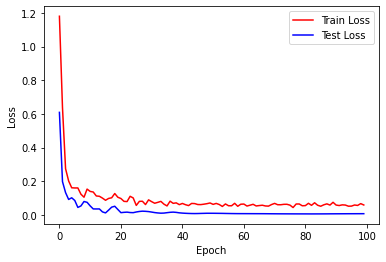

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(epochs), train_losses, color='red')
plt.plot(range(epochs), test_losses, color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [18]:
def reverse_standardization(dict, data, col_name):
  return data * dict[col_name][1] + dict[col_name][0]

In [19]:
pred = network(y_train)
pred = pred.view(-1).data.cpu().numpy()
y_test = y_test.data.cpu().numpy()
pred = reverse_standardization(mean_std, pred, 'acceleration') # Reverse Standardization
y_test = reverse_standardization(mean_std, y_test, 'acceleration') # Reverse Standardization

Text(0, 0.5, 'Value')

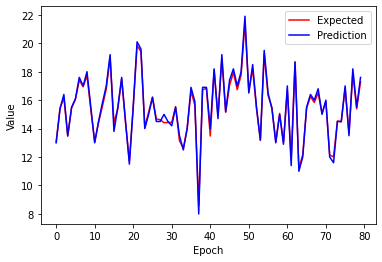

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(range(80), pred, color='red')
plt.plot(range(80), y_test, color='blue')
plt.legend(['Expected', 'Prediction'])
plt.xlabel('Epoch')
plt.ylabel('Value')